# Karla Stefania Cruz Muñiz A01661547
# **IMPLEMENTACIÓN DE UN MODELO DE DEEP LEARNING**


Tipo de capas empleadas: LSTM, batch normalization, de convolución.

[Link al dataset y a los .keras](https://drive.google.com/drive/folders/1_DRkmmzVhfGBAqBrqTZS-aDJP0iOuT-c?usp=sharing)

**Introducción**

Este proyecto está enfocado en la predicción de temperatura siguiendo series de tiempo. Útil en aplicaciones donde se requiere monitoreo y predicción en tiempo real, y puede servir como preprocesamiento para modelos de forecasting.

**Datos**

Este dataset consta de un registro cada 10 minutos durante todo un año de 20 indicadores meteorológicos. Contiene más de 52 mil registros y muestra detalladamente patrones climáticos y condiciones atmosféricas.

**Desarrollo del modelo**

Se están entregando dos modelos que cuentan con diferentes características que logran el desempeño adecuado y mejorado ante las predicciones.

Modelo 1

Arquitectura:
- Capa Conv1D con 16 filtros
- Capa LSTM de 64 unidades que si devuelven sus secuencias
- Capa LSTM de 32 unidades
- Capa Densa de 16 unidades
- Capa de salida Densa de 1 sola unidad

Modelo 2

Arquitectura:
- Capa Conv1D con 64 filtros
- Capa Dropout (0.2)
- Capa LSTM de 128 unidades
- Capa LSTM de 64 unidades
- Capa Densa de 32 unidades
- Capa de salida Densa de 1 sola unidad

Se eligió usar capas LSTM por su ajuste ante series de tiempo que es lo que estamos abordando en este momento con respecto a la Temperatura. Además se utiliza al inicio la capa de convolución para detectar patrones o variaciones específicas, que es especialmente importante en el contexto en el que estoy trabajando debido a que el clima puede cambiar drásticamente en pequeñas ventanas de tiempo.

Diferencias en la arquitectura:

La diferencia principal entre ambas arquitecturas es la profundidad con la que funcionan ambos modelos, además de la adición de la capa de dropout en el segundo modelo para tratar de evitar el sobreajuste. El aumentar la cantidad de filtros en las capas generamos una mejor captura de patrones temporales dentro de la serie de tiempo permitiendo que el modelo se ajuste de mejor manera a los resultados reales. Al final de la ejecución se puede ver en el segundo modelo que comienza a realizar un poco de overfitting al contrario del primero, pero si presenta un mejor ajuste a la validación.

Otros cambios en la arquitectura son las funciones que tiene de optimizador y de pérdida. El primer modelo utiliza SGD-MAE mientras que el segundo utiliza Adam-MSE, esto puesto que Adam le permite al modelo adaptarse mejor ante datos no lineales como en este caso la Temperatura. Además, el cambio entre MAE y MSE nos permite "castigar" más fuertemente al modelo al momento de equivocarse y ayuda a reducir errores importantes.

Entrenamiento:
- El modelo 1 usa 30% para prueba y 70% para entrenamiento
- El modelo 2 usa 10% para prueba, 10% para validación y 80% para entrenamiento.

En esta parte la principal diferencia es contar con un conjnunto de validación, permitiéndole al modelo hacer mejores ajustes, además de que aumentar el porcentaje del conjunto de entrenamiento le permite aprender con mayor cantidad de datos valga la rebundancia con el objetivo de tener una mejor generalización.

Como resultado, tenemos dos gráficas, la primera tiene un ajuste muy pobre, generando múltiples picos al momento de ser probado, pero con el segundo modelo podemos ver un ajuste mucho más preciso, y de hecho revisando el EVS en ambos modelos podemos ver cómo mejora considerablemente para el segundo.

Considero además, que los resultados del modelo en la segunda ocasión fueron muy limpios y acertados debido a la calidad del dataset que se está manejando, pues con el análisis previo podemos visualizar que son datos muy "bonitos" para trabajar con ellos.

Un área de oportunidad que detecto es el último pico en la gráfica obtenida, agregar cross fold validation y probar predecir otras variables y no solo la temperatura.

In [47]:
# Importación de librerías
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_log_error, explained_variance_score
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
# Carga del dataset
data = pd.read_csv('weather_dataset.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [49]:
data.head()

,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
date,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,5.49,1280.62,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45
2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,5.45,1280.33,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51
2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,5.43,1280.29,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60
2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,5.37,1281.97,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70
2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,5.42,1282.08,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81


In [50]:
data.columns

Index(['p', 'T', 'Tpot', 'Tdew', 'rh', 'VPmax', 'VPact', 'VPdef', 'sh', 'H2OC',
       'rho', 'wv', 'max. wv', 'wd', 'rain', 'raining', 'SWDR', 'PAR',
       'max. PAR', 'Tlog'],
      dtype='object')

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52696 entries, 2020-01-01 00:10:00 to 2021-01-01 00:00:00
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   p         52696 non-null  float64
 1   T         52696 non-null  float64
 2   Tpot      52696 non-null  float64
 3   Tdew      52696 non-null  float64
 4   rh        52696 non-null  float64
 5   VPmax     52696 non-null  float64
 6   VPact     52696 non-null  float64
 7   VPdef     52696 non-null  float64
 8   sh        52696 non-null  float64
 9   H2OC      52696 non-null  float64
 10  rho       52696 non-null  float64
 11  wv        52696 non-null  float64
 12  max. wv   52696 non-null  float64
 13  wd        52696 non-null  float64
 14  rain      52696 non-null  float64
 15  raining   52696 non-null  float64
 16  SWDR      52696 non-null  float64
 17  PAR       52696 non-null  float64
 18  max. PAR  52696 non-null  float64
 19  Tlog      52696 non-null  float6

In [52]:
data.isnull().sum()

,0
p,0
T,0
Tpot,0
Tdew,0
rh,0
VPmax,0
VPact,0
VPdef,0
sh,0
H2OC,0


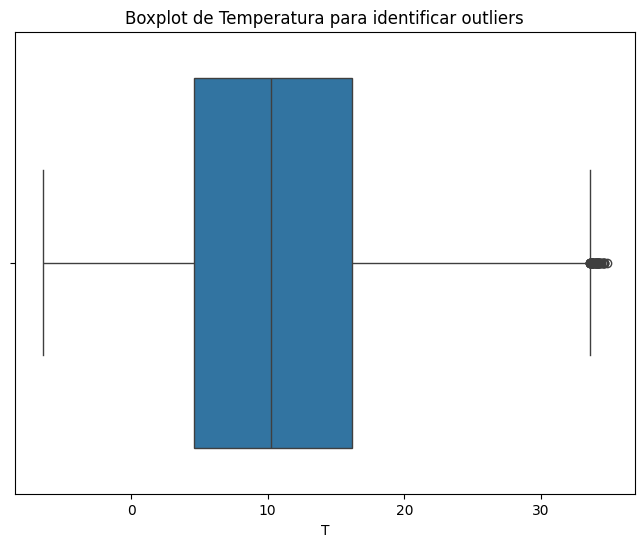

In [79]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['T'])
plt.title(f"Boxplot de Temperatura para identificar outliers")
plt.show()

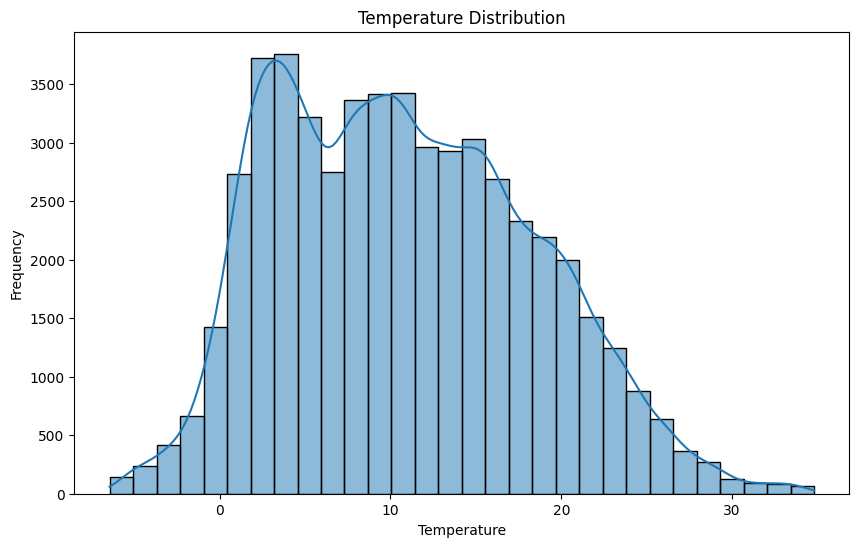

In [78]:
plt.figure(figsize=(10, 6))
sns.histplot(data['T'], bins=30, kde=True)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature Distribution")
plt.show()

# **MODELO 1**

In [53]:
# Definición de variable 'T' (Temperatura) como variable objetivo
target_variable = 'T'
X_1 = data.drop(columns=[target_variable]).values
y_1 = data[[target_variable]].values

In [54]:
# Definición de secuencia LSTM
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length_1 = 60
X_seq_1, y_seq_1 = create_sequences(X_1, y_1, seq_length_1)

In [55]:
# División en conjuntos de entrenamiento y prueba
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_seq_1, y_seq_1, test_size=0.3, random_state=42)

In [56]:
# Configuración del modelo nuevo con menor complejidad
model_1 = Sequential([
    Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_train_1.shape[1], X_train_1.shape[2])),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
model_1.compile(optimizer='sgd', loss='mae', metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 58, 16)              │             928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 58, 64)              │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,625 (135.25 KB)

 Trainable params: 34,625 (135.25 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_one = ModelCheckpoint(
    'first_weather_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    save_freq='epoch'
)

In [59]:
history_1 = model_1.fit(
    X_train_1, y_train_1,
    epochs=30,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint_one]
)

Epoch 1/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 7.6318 - mean_absolute_error: 7.6318 - root_mean_squared_error: 9.5859 - val_loss: 5.5850 - val_mean_absolute_error: 5.5850 - val_root_mean_squared_error: 6.7745
Epoch 2/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.9103 - mean_absolute_error: 4.9103 - root_mean_squared_error: 6.0034 - val_loss: 5.8083 - val_mean_absolute_error: 5.8083 - val_root_mean_squared_error: 6.9359
Epoch 3/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.2878 - mean_absolute_error: 5.2878 - root_mean_squared_error: 6.4658 - val_loss: 4.6604 - val_mean_absolute_error: 4.6604 - val_root_mean_squared_error: 5.8131
Epoch 4/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.6711 - mean_absolute_error: 4.6711 - root_mean_squared_error: 5.7605 - val_loss: 4.6929 - val_mean_absolute_error: 4.6929 - val_root_mean_squared_error: 5.7584
Epoch 5/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.7614 - mean_absolute_error: 4.7614 - root_mean_sq

In [60]:
# Evaluación del modelo
test_loss_1, test_mae_1, test_rmse_1 = model_1.evaluate(X_test_1, y_test_1, verbose=0)
print(f"Test Loss: {test_loss_1}")
print(f"Test MAE: {test_mae_1}")
print(f"Test RMSE: {test_rmse_1}")

# Predicciones y métricas adicionales
y_pred_1 = model_1.predict(X_test_1)
r2_1 = r2_score(y_test_1, y_pred_1)
mape_1 = mean_absolute_percentage_error(y_test_1, y_pred_1)
evs_1 = explained_variance_score(y_test_1, y_pred_1)

print(f"R^2: {r2_1}")
print(f"MAPE: {mape_1}")
print(f"EVS: {evs_1}")

Test Loss: 4.542643070220947
Test MAE: 4.542643070220947
Test RMSE: 5.596689224243164
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
R^2: 0.43894092930255246
MAPE: 3636419016706.7925
EVS: 0.44994573776954194


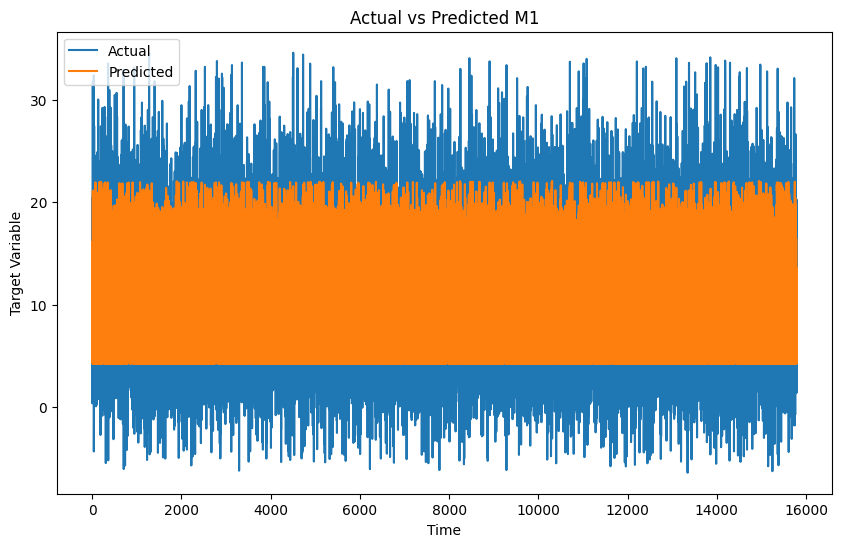

In [61]:
# Gráfica de resultados
plt.figure(figsize=(10, 6))
plt.plot(y_test_1, label='Actual')
plt.plot(y_pred_1, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.title('Actual vs Predicted M1')
plt.show()

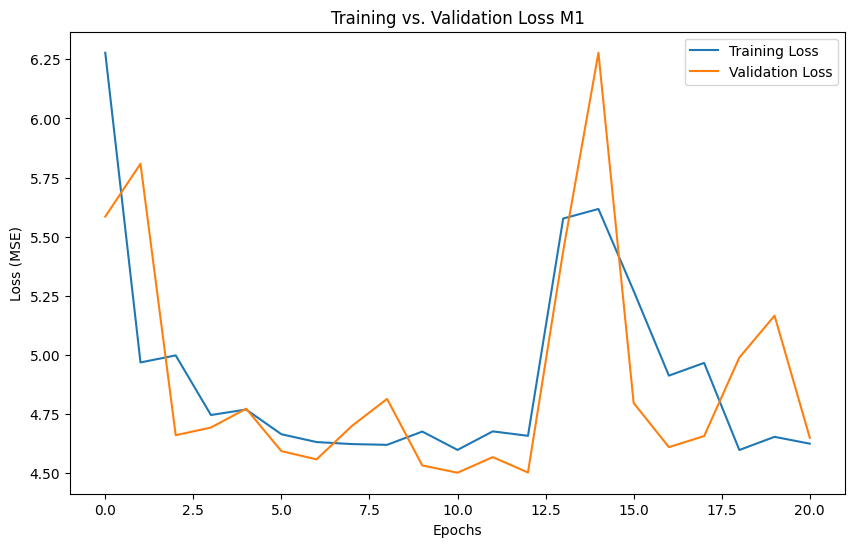

In [62]:
# Grafica training loss vs validation loss Modelo 1
plt.figure(figsize=(10, 6))
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training vs. Validation Loss M1')
plt.show()

# **MODELO 2**

In [63]:
# Selección de temperatura como variable objetivo
target_variable = 'T'
X_2 = data.drop(columns=[target_variable])
y_2 = data[[target_variable]]

In [64]:
# Evitar que la variable objetivo sea negativa para usar MSLE
y_min_2 = y_2[target_variable].min()
if y_min_2 < 0:
    y_2.loc[:, target_variable] = y_2[target_variable] - y_min_2 + 1e-6

In [65]:
# Escalado de los datos para dejarlos entre 0 y 1
scaler_X_2 = MinMaxScaler()
scaler_y_2 = MinMaxScaler()
X_scaled_2 = scaler_X_2.fit_transform(X_2)
y_scaled_2 = scaler_y_2.fit_transform(y_2)

In [66]:
seq_length = 60
X_seq_2, y_seq_2 = create_sequences(X_scaled_2, y_scaled_2, seq_length)

In [67]:
# División en conjuntos de entrenamiento, validación y prueba
X_train_2, X_temp_2, y_train_2, y_temp_2 = train_test_split(X_seq_2, y_seq_2, test_size=0.2, random_state=42)
X_val_2, X_test_2, y_val_2, y_test_2 = train_test_split(X_temp_2, y_temp_2, test_size=0.5, random_state=42)

In [68]:
model_2 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_2.shape[1], X_train_2.shape[2])),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [69]:
model_2.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
model_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 58, 64)              │           3,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 58, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 58, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,049 (601.75 KB)

 Trainable params: 154,049 (601.75 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_2 = ModelCheckpoint(
    'second_weather_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    save_freq='epoch'
)

In [71]:
history_2 = model_2.fit(
    X_train_2, y_train_2,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_2, y_val_2),
    callbacks=[early_stopping, checkpoint_2]
)

Epoch 1/20
658/658 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0039 - mean_absolute_error: 0.0320 - root_mean_squared_error: 0.0529 - val_loss: 3.1514e-04 - val_mean_absolute_error: 0.0140 - val_root_mean_squared_error: 0.0178
Epoch 2/20
658/658 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 3.3494e-04 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0183 - val_loss: 1.6030e-04 - val_mean_absolute_error: 0.0093 - val_root_mean_squared_error: 0.0127
Epoch 3/20
658/658 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 2.8366e-04 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0168 - val_loss: 2.0089e-04 - val_mean_absolute_error: 0.0109 - val_root_mean_squared_error: 0.0142
Epoch 4/20
658/658 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 2.4382e-04 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0156 - val_loss: 1.4382e-04 - val_mean_absolute_error: 0.0090 - val_root_mean_squared_error: 0.0120
Epoch 5/20
658/658 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 2.1746e-04 - mean_a

In [72]:
# Evaluación del modelo
test_loss_2, test_mae_2, test_rmse_2 = model_2.evaluate(X_test_2, y_test_2, verbose=0)
print(f"Test Loss (MSE): {test_loss_2}")
print(f"Test MAE: {test_mae_2}")
print(f"Test RMSE: {test_rmse_2}")

# Transformación inversa
y_pred_scaled_2 = model_2.predict(X_test_2)
y_pred_2 = scaler_y_2.inverse_transform(y_pred_scaled_2)
y_test_2 = scaler_y_2.inverse_transform(y_test_2)

# Evitar que la variable objetivo sea negativa
y_min_2 = y_2[target_variable].min()
if y_min_2 < 0:
    y_2[target_variable] = y_2[target_variable] - y_min_2 + 1e-6

# Métricas adicionales
r2_2 = r2_score(y_test_2, y_pred_2)
mape_2 = mean_absolute_percentage_error(y_test_2, y_pred_2)
msle_2 = mean_squared_log_error(y_test_2, y_pred_2)
msle_2 = mean_squared_log_error(y_test_2, y_pred_2)
evs_2 = explained_variance_score(y_test_2, y_pred_2)

print(f"R^2 (Coefficient of Determination): {r2_2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_2}")
print(f"Mean Squared Log Error (MSLE): {msle_2}")
print(f"EVS: {evs_2}")

Test Loss (MSE): 6.581856723641977e-05
Test MAE: 0.006133470684289932
Test RMSE: 0.008112864568829536
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
R^2 (Coefficient of Determination): 0.9979531591971744
Mean Absolute Percentage Error (MAPE): 0.0196733181132887
Mean Squared Log Error (MSLE): 0.000716000133983099
EVS: 0.9980224304856088


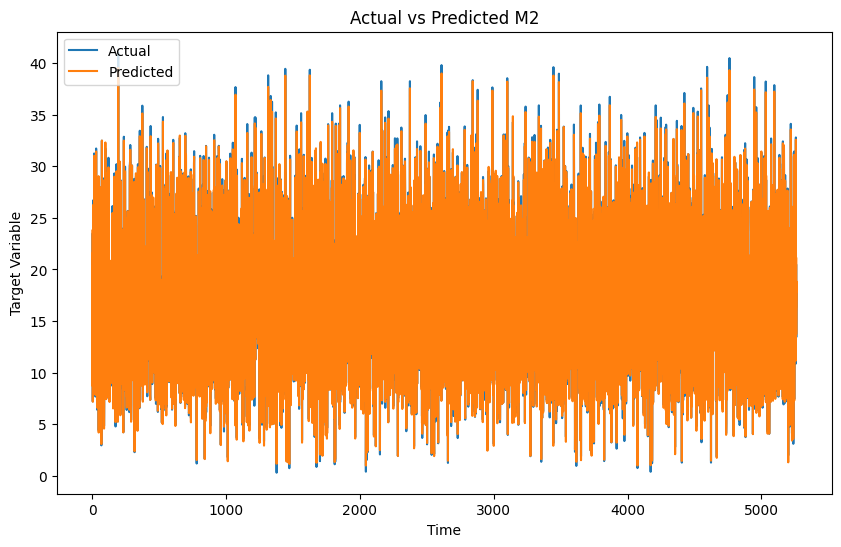

In [73]:
# Gráfica de resultados
plt.figure(figsize=(10, 6))
plt.plot(y_test_2, label='Actual')
plt.plot(y_pred_2, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.title('Actual vs Predicted M2')
plt.show()

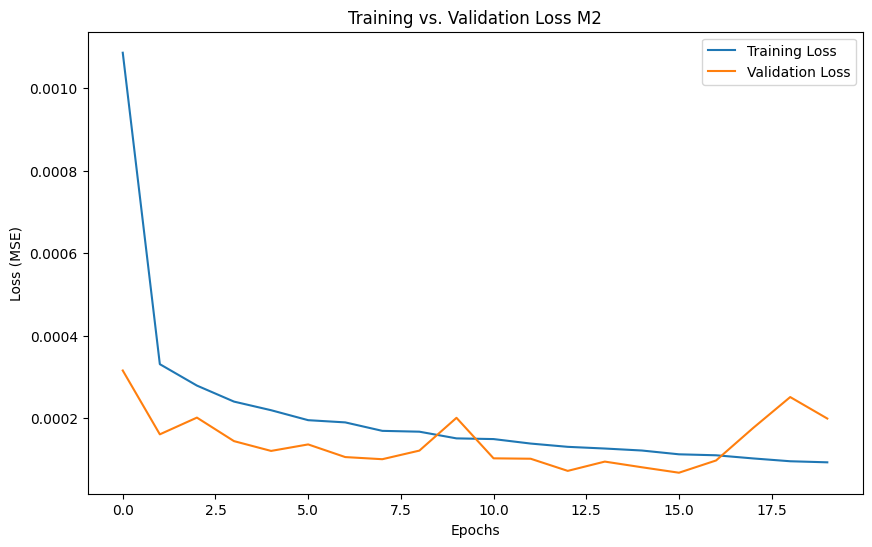

In [74]:
# Grafica training loss vs validation loss Modelo 2
plt.figure(figsize=(10, 6))
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training vs. Validation Loss M2')
plt.show()